# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [1]:
!git clone -b main https://github.com/StarkitRobots/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 321 (delta 0), reused 1 (delta 0), pack-reused 315
Receiving objects: 100% (321/321), 46.68 MiB | 35.46 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Чтение изображений

In [3]:
def read_images(path):
    result_img = []
    names = []
    for name in sorted(os.listdir(path)):
        path_to_img = os.path.join(path, name)
        image = cv2.imread(path_to_img, cv2.IMREAD_COLOR)
        result_img.append(image)
        names.append(name)
    return result_img, names


path = 'cvr_course/data/imgs/arrow/'
images, img_names = read_images(path)
print(f'Кол-во изображений: {len(images)}')

Кол-во изображений: 10


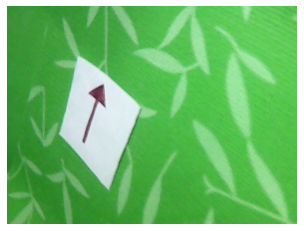

In [4]:
def visualize_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()


idx = np.random.randint(len(images))
visualize_image(images[idx])

## Расстояние до листка

In [5]:
def find_contour(img, low_th, high_th):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.inRange(img, low_th, high_th)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(contours, key=len, reverse=True)[0]
    approx = cv2.convexHull(cnt)
    epsilon = 0.05 * cv2.arcLength(approx, True)
    approx = cv2.approxPolyDP(approx, epsilon, True)
    return approx


def find_distance(img, th, eps=1e-10):
    low_th  = th[0]
    high_th = th[1]
    contour = find_contour(img, low_th, high_th)
    length = cv2.arcLength(contour, True)
    distance = 180.0 * 364 / (length + eps)
    return distance


def get_distances(images, names):
    distances = []
    thresholds = [((170, 200, 185), (255, 255, 255)),
                  ((150, 200, 200), (255, 255, 255)),
                  ((150, 200, 200), (255, 255, 255)),
                  ((190, 190, 190), (255, 255, 255)),
                  ((160, 200, 200), (255, 255, 255)),
                  ((160, 160, 160), (255, 255, 255)),
                  ((200, 200, 200), (255, 255, 255)),
                  ((160, 190, 190), (255, 255, 255)),
                  ((200, 200, 200), (255, 255, 255)),
                  ((160, 190, 190), (255, 255, 255))]

    for idx, image in enumerate(images):
        dist = find_distance(image, thresholds[idx])
        print(f'Distance in the image {names[idx]}: {dist}')
        distances.append(dist)
    return distances

In [6]:
distances = get_distances(images, img_names)

Distance in the image vlcsnap-2020-10-21-18h01m22s212.png: 92.95653286263742
Distance in the image vlcsnap-2020-10-21-18h01m27s294.png: 90.41601989946886
Distance in the image vlcsnap-2020-10-21-18h01m29s941.png: 90.7385411789481
Distance in the image vlcsnap-2020-10-21-18h01m33s362.png: 94.43105761244476
Distance in the image vlcsnap-2020-10-21-18h01m36s056.png: 93.1532743789519
Distance in the image vlcsnap-2020-10-21-18h01m41s874.png: 89.82386616349172
Distance in the image vlcsnap-2020-10-21-18h01m44s163.png: 86.98571825074993
Distance in the image vlcsnap-2020-10-21-18h01m46s644.png: 75.26225281362858
Distance in the image vlcsnap-2020-10-21-18h01m49s487.png: 58.21389817916682
Distance in the image vlcsnap-2020-10-21-18h01m51s638.png: 57.37311409707645


## Bird view

In [7]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    min_ = np.argmin(s)
    max_ = np.argmax(s)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    pts = [value for idx, value in enumerate(pts) if idx not in [min_, max_]]
    
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1).reshape(-1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # return the ordered coordinates
    return rect


def get_mask(image, th=((200, 200, 200), (255, 255, 255)), three_channel=True):
    low_th  = th[0]
    high_th = th[1]
    mask = cv2.inRange(image, low_th, high_th)
    if three_channel:
        new_img = np.zeros_like(image)
        new_img[:, :, 0] = mask
        new_img[:, :, 1] = mask
        new_img[:, :, 2] = mask
        return new_img
    return mask


def get_contour(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(contours, key=len, reverse=True)[0]
    approx = cv2.convexHull(cnt)
    epsilon = 0.05 * cv2.arcLength(approx, True)
    approx = cv2.approxPolyDP(approx, epsilon, True)
    return approx


def get_bird_view(images):
    thresholds = [((170, 200, 185), (255, 255, 255)),
                  ((150, 200, 200), (255, 255, 255)),
                  ((150, 200, 200), (255, 255, 255)),
                  ((185, 185, 185), (255, 255, 255)),
                  ((160, 200, 200), (255, 255, 255)),
                  ((160, 160, 160), (255, 255, 255)),
                  ((200, 200, 200), (255, 255, 255)),
                  ((160, 190, 190), (255, 255, 255)),
                  ((200, 200, 200), (255, 255, 255)),
                  ((160, 190, 190), (255, 255, 255))]

    warped_imgs = []
    for idx, image in enumerate(images):
        mask = get_mask(image, thresholds[idx], three_channel=False)
        approx = get_contour(mask)
        warped = four_point_transform(image, np.asarray(approx)[:, 0, :])
        warped_imgs.append(warped)
    return warped_imgs

In [8]:
warped_images = get_bird_view(images)

In [9]:
def visualize_img_and_its_warped(img, warped):
    fig, arr = plt.subplots(1, 2, figsize=(14, 8))
    arr[0].imshow(img)
    arr[0].axis('off')
    arr[0].set_title('Input image')
    arr[1].imshow(warped)
    arr[1].axis('off')
    arr[1].set_title('Warped image')

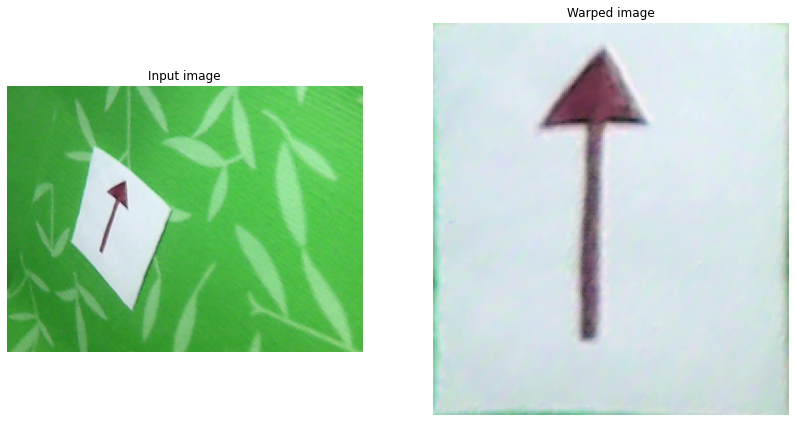

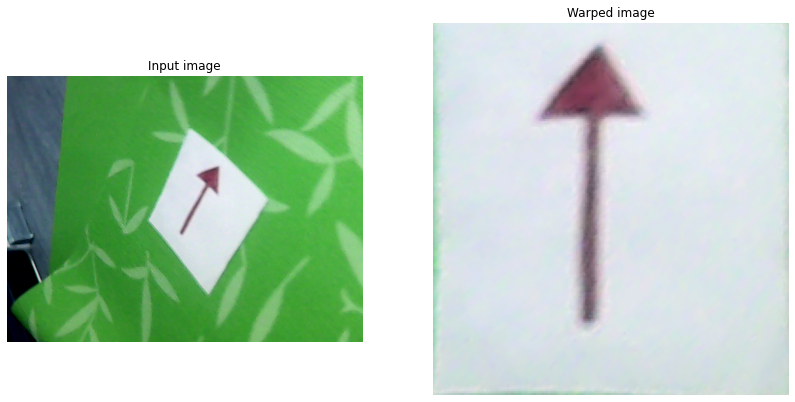

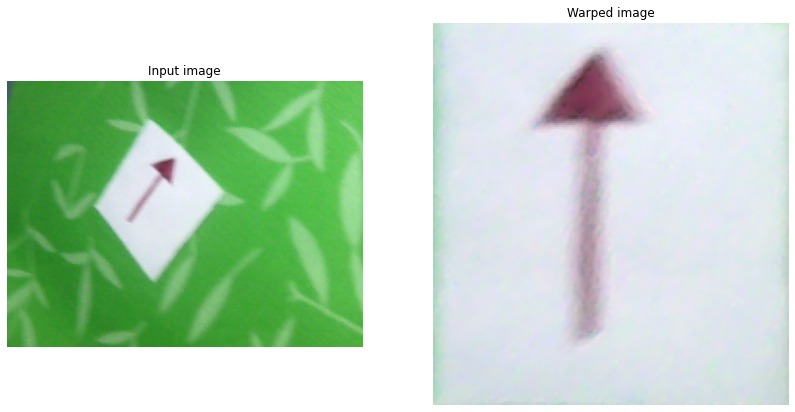

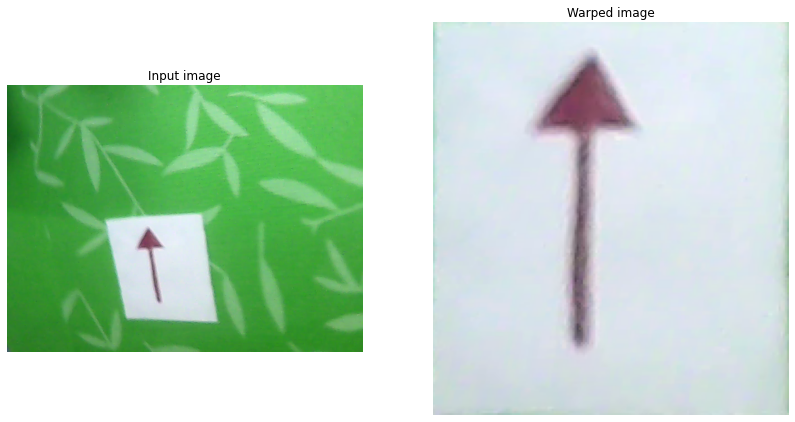

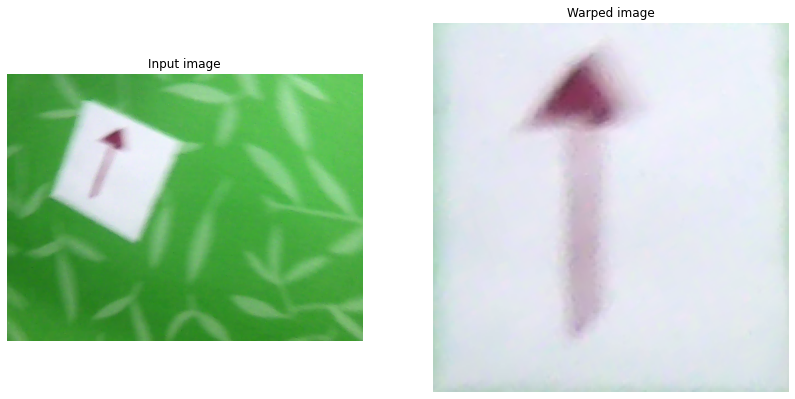

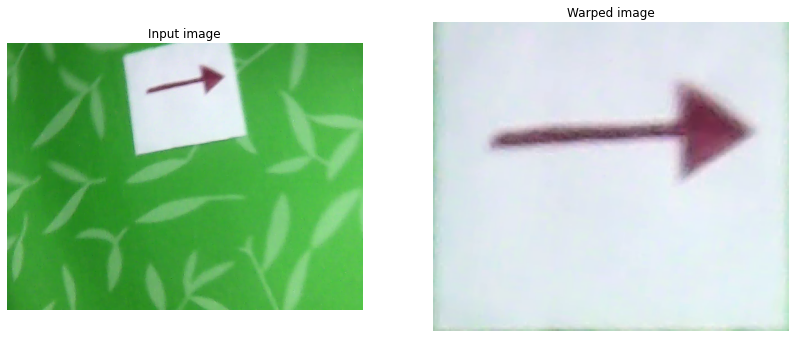

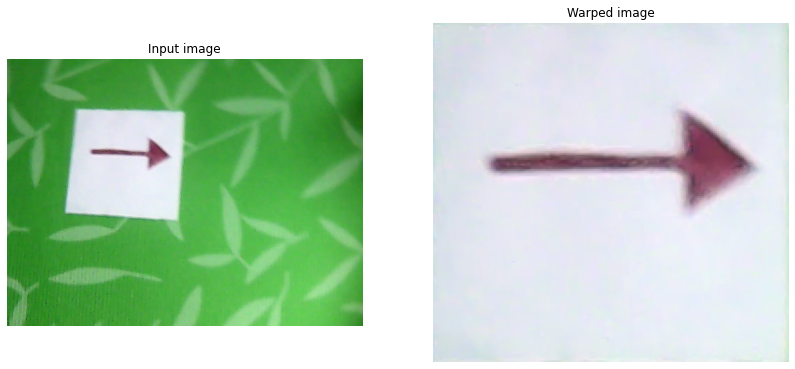

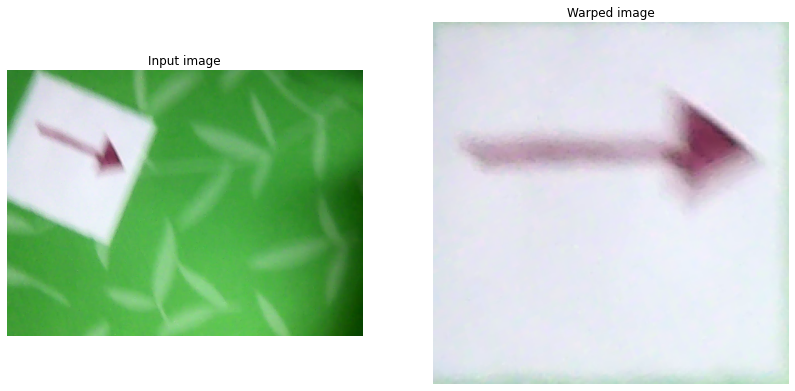

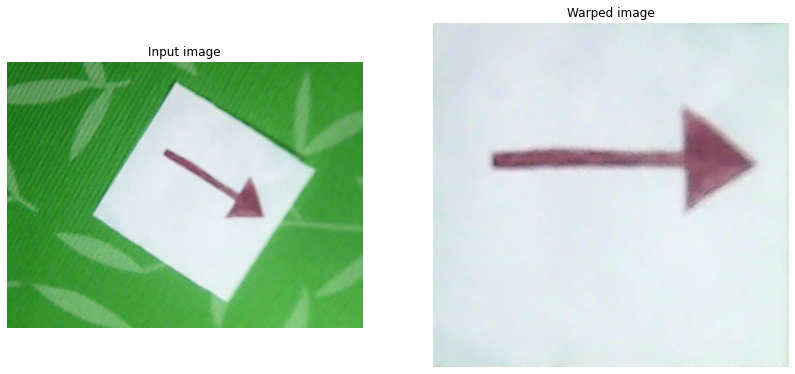

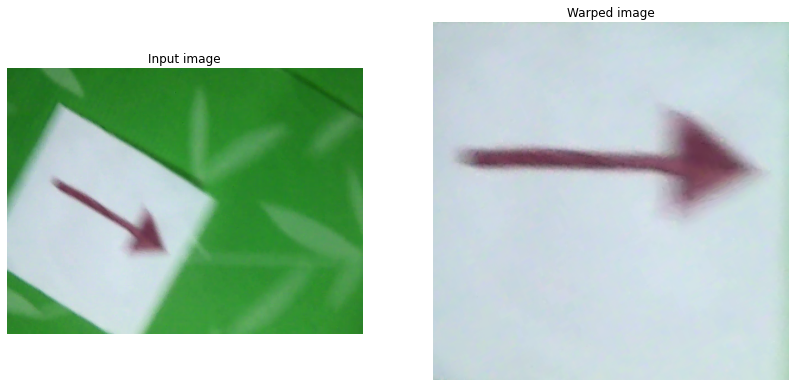

In [10]:
for pair in list(zip(images, warped_images)):
    visualize_img_and_its_warped(pair[0], pair[1])

## Определение направления

In [21]:
def get_directions(images):
    points = []
    thresholds = [((170, 200, 185), (255, 255, 255)),
                  ((150, 200, 200), (255, 255, 255)),
                  ((150, 200, 200), (255, 255, 255)),
                  ((185, 185, 185), (255, 255, 255)),
                  ((160, 200, 200), (255, 255, 255)),
                  ((160, 160, 160), (255, 255, 255)),
                  ((200, 200, 200), (255, 255, 255)),
                  ((160, 190, 190), (255, 255, 255)),
                  ((200, 200, 200), (255, 255, 255)),
                  ((160, 190, 190), (255, 255, 255))]
    for idx, image in enumerate(images):
        mask = get_mask(image, thresholds[idx], three_channel=False)
        sobelX = cv2.Sobel(mask, cv2.CV_8U, 1, 0, ksize=5)
        sobelY = cv2.Sobel(mask, cv2.CV_8U, 0, 1, ksize=5)
        # Направление градиентов
        teta = np.arctan2(sobelY, sobelX)
        # Так и не понял, как интерпетировать значения в teta
        # Умного ничего не придумал, кроме как пройтись 
        # скользящим окном по массиву и подсчитать, где больше
        # всего сумма.
        h, w = teta.shape
        mid = h // 2, w // 2
        mass_center = h // 2, w // 2
        max_summa = 0
        length = 30 # Наугад подобрал
        for x in range(h):
            for y in range(w):
                summa = np.sum(teta[x:x+length, y:y+length])
                if summa > max_summa:
                    max_summa = summa
                    mass_center = (x + length // 2, y + length // 2)
        points.append((mass_center, mid))
    return points

In [22]:
points_and_centers = get_directions(warped_images)

In [23]:
print(points_and_centers)

[((57, 77), (96, 87)), ((44, 66), (98, 93)), ((65, 64), (98, 91)), ((144, 63), (94, 85)), ((66, 72), (93, 90)), ((72, 127), (86, 99)), ((92, 128), (94, 98)), ((95, 148), (113, 111)), ((129, 191), (139, 144)), ((140, 183), (151, 150))]


## Видео

In [ ]:
cd drive/My Drive/Robotics

/content/drive/My Drive/Robotics


In [ ]:
def get_bird_view_on_video(image):
    mask = get_mask(image, three_channel=False)
    approx = get_contour(mask)
    warped = four_point_transform(image, np.asarray(approx)[:, 0, :])

    # Так как переменная warped всегда разного размера, то придется
    # приводить её к фиксированному формату.
    new_frame = np.zeros((480, 640, 3), dtype=warped.dtype)
    h, w = warped.shape[0], warped.shape[1]
    new_frame[:h, :w, :] = warped
    return new_frame

In [ ]:
from moviepy.editor import VideoFileClip

def process_video(path):
    clip = VideoFileClip(path)
    result = clip.fl_image(get_mask)
    result.write_videofile('result_video/result1.mp4', audio=False)

    clip_2 = VideoFileClip(path)
    result_2 = clip_2.fl_image(get_bird_view_on_video)
    result_2.write_videofile('result_video/result2.mp4', audio=False)

In [ ]:
path = "3.mp4"
process_video(path)

[MoviePy] >>>> Building video result_video/result2.mp4
[MoviePy] Writing video result_video/result2.mp4


100%|█████████▉| 245/246 [00:03<00:00, 80.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video/result2.mp4 



Ссылка на первое видео: https://yadi.sk/i/eMCF-jNnXigv8w

Ссылка на второе видео: https://yadi.sk/i/mVSCwAGERj_XIw